In this file we will be exploring methods for improving the quality of the cloud mask results.

In particular, we will be looking at:

- Dilation to remove the effect of the boundary conditions
- Erosion to remove the effect of small noise - possibly not needed
- Closing to remove small holes in the output
- Opening to remove the effects of small noise - possibly

In [2]:
import numpy as np
import cv2 as cv
import numpy as np
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150

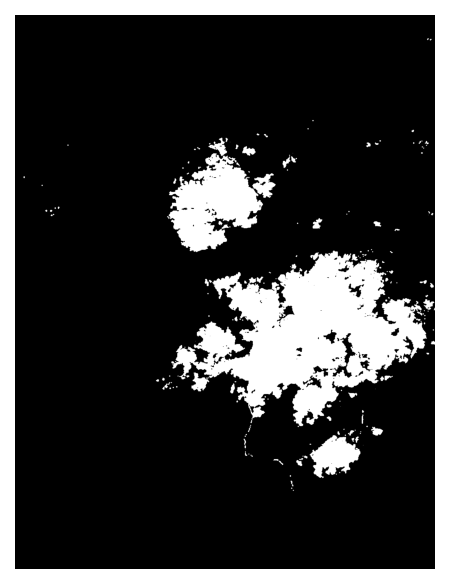

In [27]:
base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570/2019-05-22/testing_cloud_detection")

new_mask = rasterio.open(base_path.joinpath("new_mask.tif")).read(1)

plt.imshow(new_mask, cmap=plt.cm.gray)
plt.axis("off")

rgb = rasterio.open(base_path.parent.joinpath("RGB.tif")).read()
rgb_image = np.transpose(rgb, (1, 2, 0))

norm = colors.Normalize(vmin=rgb_image.min(), vmax=rgb_image.max())
rgb_image = norm(rgb_image)

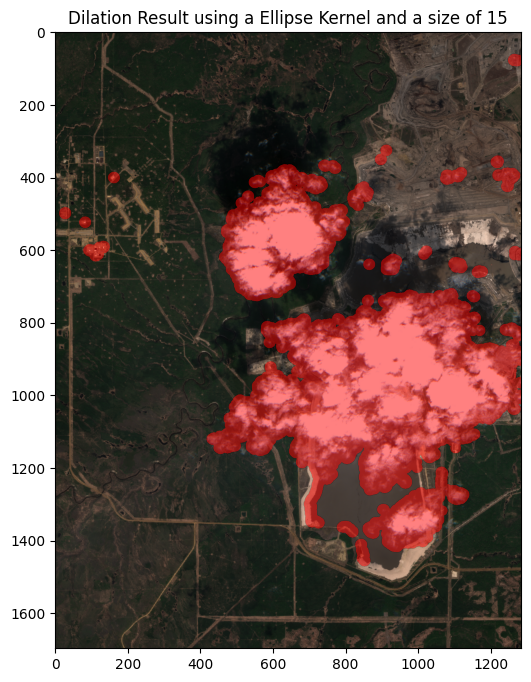

In [44]:
dilation_size = 15
dilation_shape = cv.MORPH_ELLIPSE
element = cv.getStructuringElement(dilation_shape, (2 * dilation_size + 1, 2 * dilation_size + 1))

dilatation_dst = cv.dilate(new_mask, element)

plt.figure(figsize=(10, 8))

mask_image = np.zeros((*dilatation_dst.shape, 4))
mask_image[..., 0] = dilatation_dst
mask_image[..., 3] = dilatation_dst * 0.5
plt.imshow(rgb_image)
plt.imshow(mask_image)
plt.title(f"Dilation Result using a Ellipse Kernel and a size of {dilation_size}")

plt.savefig("comparing_dilation.png", dpi=300, bbox_inches="tight")

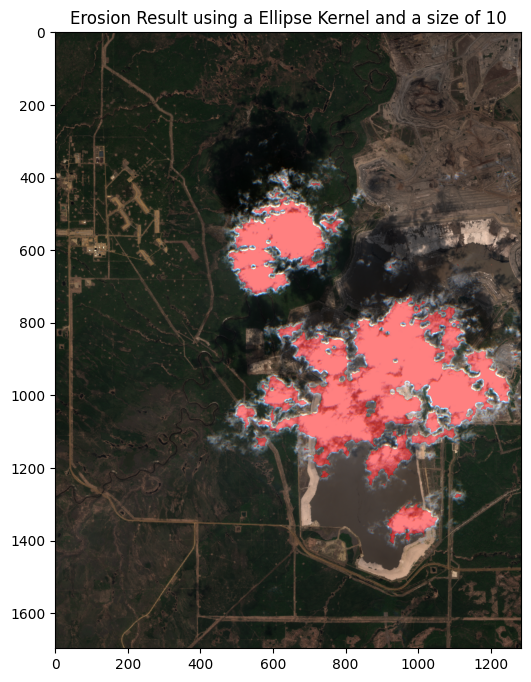

In [40]:
# Erosion

erosion_size = 5
erosion_shape = cv.MORPH_ELLIPSE
element = cv.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1))

erosion_dst = cv.erode(new_mask, element)

plt.figure(figsize=(10, 8))

mask_image = np.zeros((*erosion_dst.shape, 4))
mask_image[..., 0] = erosion_dst
mask_image[..., 3] = erosion_dst * 0.5
plt.imshow(rgb_image)
plt.imshow(mask_image)
plt.title(f"Erosion Result using a Ellipse Kernel and a size of {dilation_size}")

plt.savefig("comparing_erosion.png", dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'Open Result using a Ellipse Kernel and a size of 3')

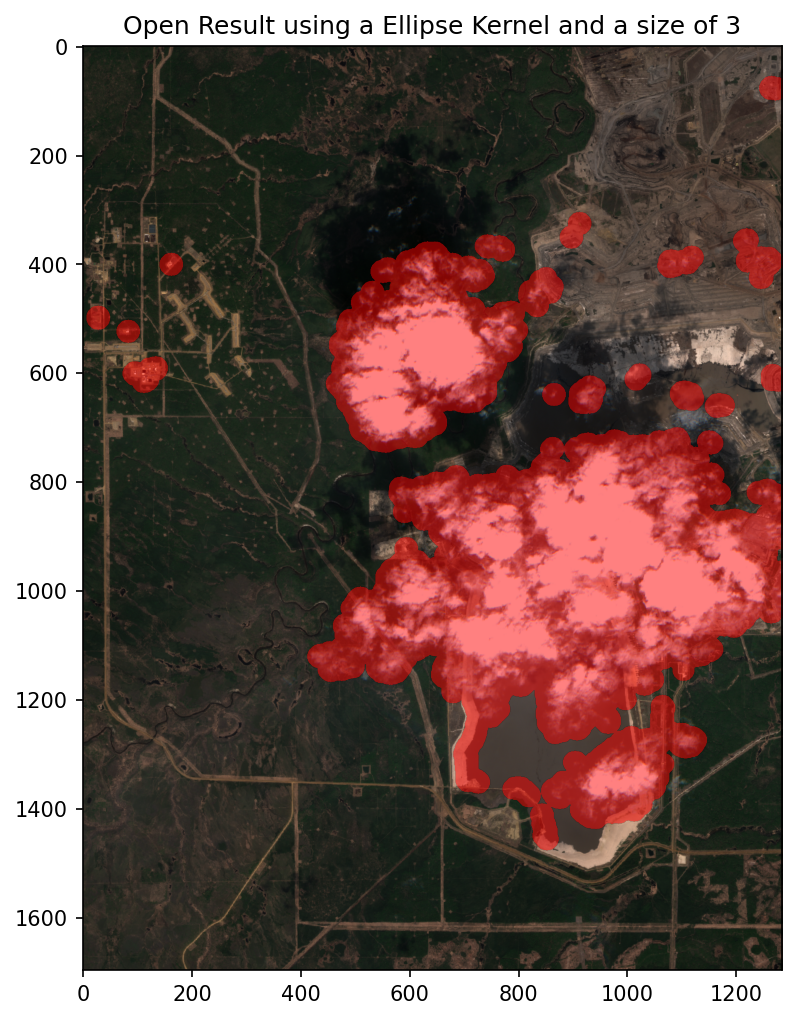

In [40]:
# Open to remove small, noisy pixels

open_size = 3
open_shape = cv.MORPH_ELLIPSE
element = cv.getStructuringElement(open_shape, (2 * open_size + 1, 2 * open_size + 1))
open_op = cv.MORPH_OPEN

open_dst = cv.morphologyEx(new_mask, open_op, element)

dilation_size = 20
element = cv.getStructuringElement(open_shape, (2 * dilation_size + 1, 2 * dilation_size + 1))
dilation_dst = cv.dilate(new_mask, element)

plt.figure(figsize=(10, 8))

mask_image = np.zeros((*open_dst.shape, 4))
mask_image[..., 0] = dilation_dst
mask_image[..., 3] = dilation_dst * 0.5
plt.imshow(rgb_image)
plt.imshow(mask_image)
plt.title(f"Open Result using a Ellipse Kernel and a size of {open_size}")

In [ ]:
# Flood fill, then remove any very small regions?



Text(0.5, 1.0, 'Our Method')

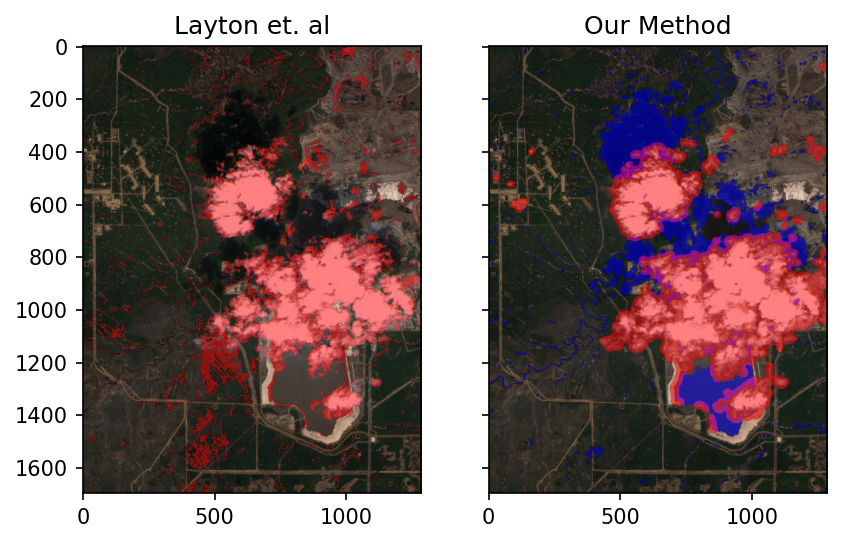

In [43]:
# Compare the old results to the new results

old_result = rasterio.open(base_path.parent.joinpath("old_cloud_mask.tif")).read(1)
new_result = rasterio.open(base_path.parent.joinpath("cloud_mask.tif")).read(1)

new_shadows = rasterio.open(base_path.parent.joinpath("potential_shadows.tif")).read(1)

fig, ax = plt.subplots(1, 2, sharey=True)
mask_image = np.zeros((*old_result.shape, 4))
mask_image[..., 0] = old_result
mask_image[..., 3] = old_result * 0.5
ax[0].imshow(rgb_image)
ax[0].imshow(mask_image)
ax[0].set_title("Layton et. al")

mask_image[..., 0] = new_result
mask_image[..., 2] = new_shadows
mask_image[..., 3] = np.bitwise_or(new_result, new_shadows) * 0.5
ax[1].imshow(rgb_image)
ax[1].imshow(mask_image)
ax[1].set_title("Our Method")